### Collaborative filtering using fast ai

In [3]:
from fastai.tabular.all import *
from fastai.collab import *
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [4]:
#loading the dataset
ratings = pd.read_csv('u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [6]:
#loading the movie code title
movies = pd.read_csv('u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [75]:
#loading the test dataset for predictions
ratings1 = pd.read_csv('u1.test', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
Test_data = ratings1.merge(movies)
#Test_data.head()
Test_data1 = CollabDataLoaders.from_df(Test_data, item_name='title', bs=64)
Test_data1.show_batch()

,user,title,rating
0,14,"Celluloid Closet, The (1995)",2
1,135,"Hunt for Red October, The (1990)",3
2,135,Killing Zoe (1994),3
3,172,Rear Window (1954),3
4,6,Mr. Holland's Opus (1995),3
5,201,William Shakespeare's Romeo and Juliet (1996),2
6,60,Lawrence of Arabia (1962),4
7,189,"Adventures of Pinocchio, The (1996)",5
8,42,Independence Day (ID4) (1996),4
9,197,As Good As It Gets (1997),4


In [96]:
# sorted(Test_data['user'].value_counts().index)

In [8]:
#merging the dataframe to replace movie with title
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [95]:
# sorted(ratings['user'].value_counts().index)

In [9]:
#using the collaborative filtering data loader 
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [10]:
dls.show_batch()

,user,title,rating
0,896,Unforgiven (1992),5
1,297,Ed Wood (1994),2
2,846,Terminal Velocity (1994),2
3,95,"Manchurian Candidate, The (1962)",5
4,916,M. Butterfly (1993),3
5,864,Stargate (1994),4
6,429,"Empire Strikes Back, The (1980)",5
7,21,Unforgettable (1996),2
8,845,"English Patient, The (1996)",5
9,450,Pink Floyd - The Wall (1982),1


In [11]:
#using collaborative filtering learner to get the embedding and to make predictions
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

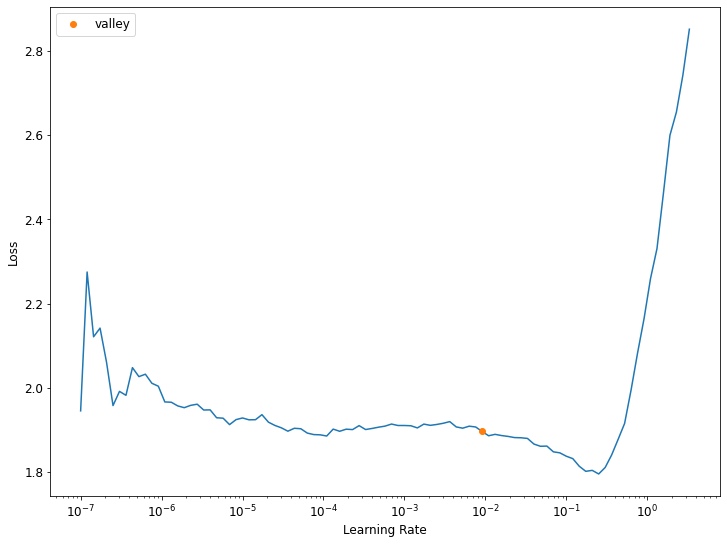

In [12]:
#the following code plots and finds the ideal learning rate for the model
lr = learn.lr_find()

In [13]:
lr

SuggestedLRs(valley=0.009120108559727669)

In [14]:
# learn.fit_one_cycle(5, 5e-3, wd=0.1)

In [15]:
#fitting the model in 5 cycles and using the suggested learning rate
learn.fit_one_cycle(5, lr, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.947879,0.950871,00:07
1,0.885012,0.887456,00:08
2,0.740532,0.843874,00:08
3,0.553342,0.830003,00:08
4,0.386865,0.833491,00:08


In [16]:
# learn.fit_one_cycle(10, 1e-1, wd=0.1)

In [17]:
user_id = 1
movie_id = 100
input_data = {'user_id': user_id, 'movie_id': movie_id}

In [76]:
Test_data=Test_data.drop(['rating','movie'],axis=1)

In [77]:
dl = learn.dls.test_dl(Test_data, bs=64) # apply transforms on the test data
preds,  _ = learn.get_preds(dl=dl) # get predictions on the test data

In [78]:
dl.show_batch()

,user,title
0,1,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
1,9,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
2,63,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
3,79,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
4,90,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
5,409,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
6,1,Richard III (1995)
7,7,Richard III (1995)
8,49,Richard III (1995)
9,59,Richard III (1995)


In [79]:
preds #predicted values

tensor([4.1729, 4.3269, 3.1407,  ..., 4.1442, 2.9892, 4.0049])

In [98]:
pd.DataFrame(preds.numpy(),columns=["Prediction"] ).head(10)#predicted values in a data frame

,Prediction
0,4.172879
1,4.326862
2,3.140697
3,4.168423
4,4.267342
5,3.732576
6,3.729470
7,4.075462
8,4.010137
9,3.723830


In [81]:
Test_data.head(10)

,user,title
0,1,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
1,9,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
2,63,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
3,79,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
4,90,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
5,409,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
6,1,Richard III (1995)
7,7,Richard III (1995)
8,49,Richard III (1995)
9,59,Richard III (1995)


In [82]:
#getting the top 1000 viewed movies
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

In [59]:
#finding the mean  rating for the above top 1000 movies
h = ratings.groupby('title')['rating'].mean()
pd.DataFrame(h)

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390
...,...
Young Guns II (1990),2.772727
"Young Poisoner's Handbook, The (1995)",3.341463
Zeus and Roxanne (1997),2.166667


In [63]:
meta_data=pd.DataFrame(top_movies,columns=["title"] ).merge(pd.DataFrame(h),left_on="title", right_on="title")

In [64]:
#Getting the meta data in a tsv file to be used in embbeding projector
meta_data.to_csv('metadata.tsv', index=False, sep='\t')

In [49]:
#getting the bias for each of the top 1000 movies
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [26]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [27]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.4616),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3985),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3767), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3693), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.3525), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.3377), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.3339), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.3249), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3059), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.3029), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2981), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2835), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2774), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2707), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2670), 'Tales from the Hood (199

In [28]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.7077), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.6960), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6634), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.6565), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.6504), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6449), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6437), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.6296), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.6281), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.6275), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.6192), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5876), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5680), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.5656), 'Apt Pupil (1998)', 4.1),
 (tensor(0.5625), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667)]

In [ ]:
#Movie_weights

In [50]:
#finding the weight or the embbeding vector
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [30]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [65]:
embedding_df=pd.DataFrame(movie_w)

In [66]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.308528,-0.013217,0.288833,-0.291891,-0.227148,-0.298180,0.308640,-0.484184,-0.228409,0.179538,...,-0.240356,0.569082,0.407731,-0.241692,-0.161494,-0.252329,0.045817,0.350174,0.227110,-0.370955
1,0.068197,-0.429078,-0.172423,0.281694,0.435428,-0.006195,0.299924,-0.417406,-0.258230,-0.045066,...,-0.003249,0.389922,-0.177987,-0.204373,0.447197,-0.326505,-0.022198,0.083480,0.220716,-0.376042
2,-0.273482,-0.359337,-0.286360,-0.002652,0.320630,-0.221947,0.094865,0.186873,-0.079958,0.334368,...,-0.109814,0.308935,0.140578,0.406091,-0.226519,-0.231256,0.206547,-0.195823,0.205395,-0.173194
3,0.467282,0.188244,0.120499,-0.235398,-0.297719,-0.289606,0.375755,-0.376754,-0.337205,-0.092261,...,-0.014364,0.416114,0.287444,-0.471970,-0.064032,-0.226923,0.319533,0.501317,0.144242,-0.003146
4,0.246266,0.034584,0.398575,-0.179038,0.181393,-0.029419,-0.372054,-0.383708,-0.071520,0.006908,...,0.199087,0.114092,-0.030003,0.162205,0.387994,-0.281378,-0.185605,0.628066,0.245188,0.079691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.222492,-0.043528,0.045183,-0.059561,-0.010350,0.270981,-0.146375,0.055593,-0.012799,0.188300,...,0.067747,0.143483,0.351450,0.335542,0.061042,-0.047920,0.118769,-0.012566,0.218776,0.087219
996,-0.129964,-0.060576,0.289461,-0.192462,0.041351,-0.167122,0.073931,-0.057316,0.120499,0.056051,...,0.019326,0.146520,-0.013119,0.151502,-0.007980,-0.054441,-0.035259,-0.050315,0.109793,0.048048
997,0.063106,0.074149,-0.008419,-0.006145,0.099705,-0.103635,0.135635,-0.040569,0.047257,0.079023,...,-0.183934,-0.158001,-0.208649,0.018592,0.136493,-0.153188,0.031344,-0.090746,0.184516,0.155743
998,0.209689,0.124338,-0.080780,-0.183504,-0.026510,0.112885,-0.029859,-0.041147,-0.239374,-0.245365,...,0.089347,-0.183906,-0.132240,-0.044856,-0.000080,0.329104,-0.190485,0.277385,-0.312892,0.107411


In [67]:
#getting a tsv file for the embedding vector to visualize in the embbeding projector
embedding_df.to_csv('Embedding_output.tsv', sep='\t', index=None, header=None)

In [31]:
#Using pca to reduce dimension from 50 to 3
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

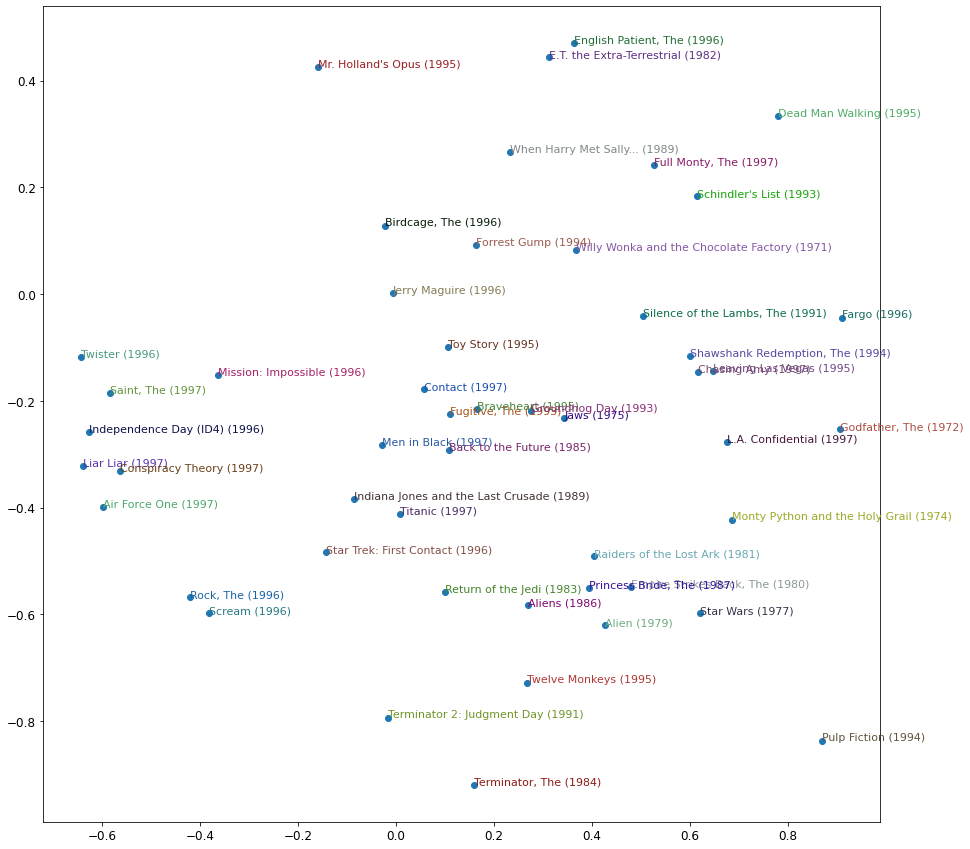

In [39]:
#Ploting 2d embbeding
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()